## Нормализованный датасет

In [1]:
import os
import pandas as pd

os.chdir('../../../')

In [2]:
df_normalized = pd.read_csv('data/lmsys-chat-1m/processed/features_normalized.csv',)

### Матрица корреляции

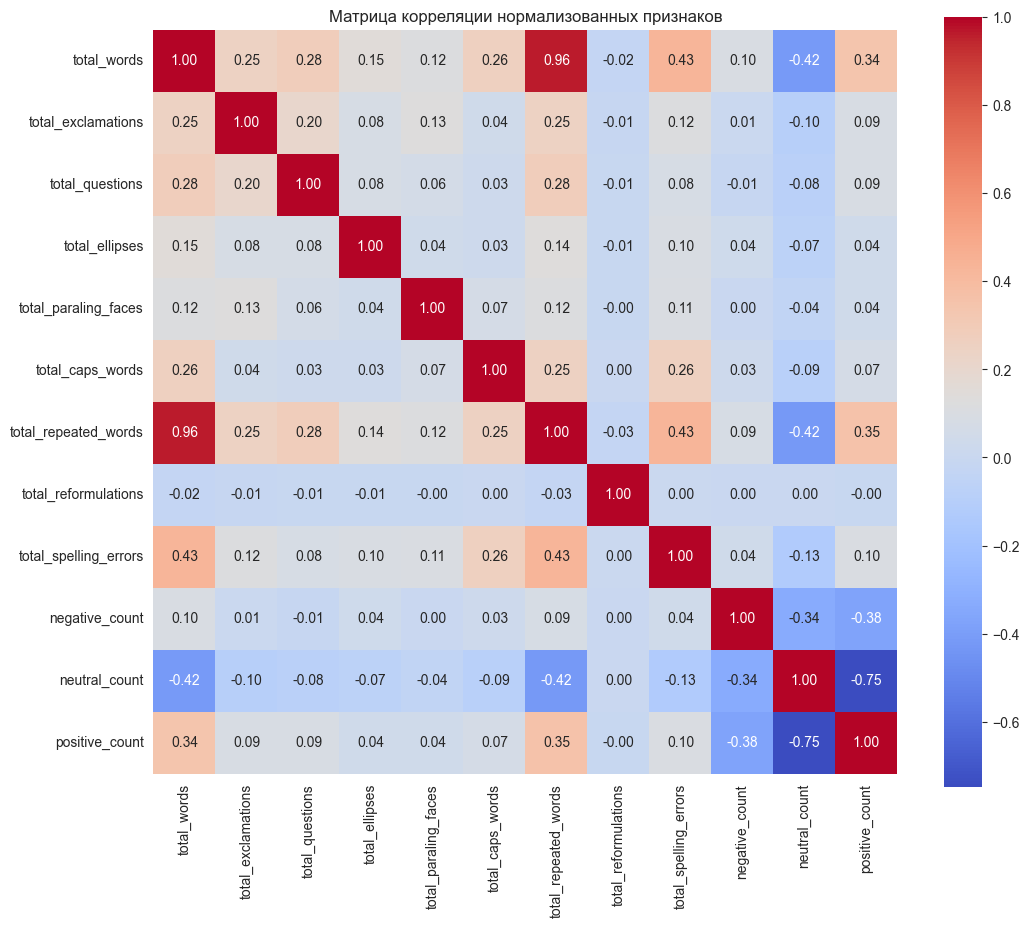

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = [
    col for col in df_normalized.columns
    if col != 'user_id' and pd.api.types.is_numeric_dtype(df_normalized[col])
]

# Строим матрицу корреляции
corr_matrix = df_normalized[numeric_cols].corr()

# Визуализация
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Матрица корреляции нормализованных признаков")
plt.show()


### Уберем признаки с сильной корреляцией

In [4]:
df_normalized.drop(['total_repeated_words'], inplace=True, axis=1)
# df_normalized.drop(['neutral_count'], inplace=True, axis=1)


### Подготовка данных

In [5]:
# pip install hdbscan

import numpy as np
from sklearn.preprocessing import StandardScaler

X = df_normalized.drop(columns=['user_id'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Подвыборка для начала (если весь X_scaled слишком большой)
sample_size = 30000
idx_sample = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sampled = X_scaled[idx_sample]

# user_id'ы соответствующие этой выборке
user_ids_sampled = df_normalized.iloc[idx_sample]['user_id'].values


### Обучение модели

In [6]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=30,
    min_samples=10,
    metric='euclidean',
    prediction_data=True
)

hdb_labels = clusterer.fit_predict(X_sampled)

df_hdbscan_clusters = pd.DataFrame({
    'user_id': user_ids_sampled,
    'hdbscan_cluster': hdb_labels
})


C:\Users\hqdem\PythonProjects\user-pattern-analysis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hqdem\PythonProjects\user-pattern-analysis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Визуализация

C:\Users\hqdem\AppData\Local\Temp\ipykernel_24712\2040777755.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


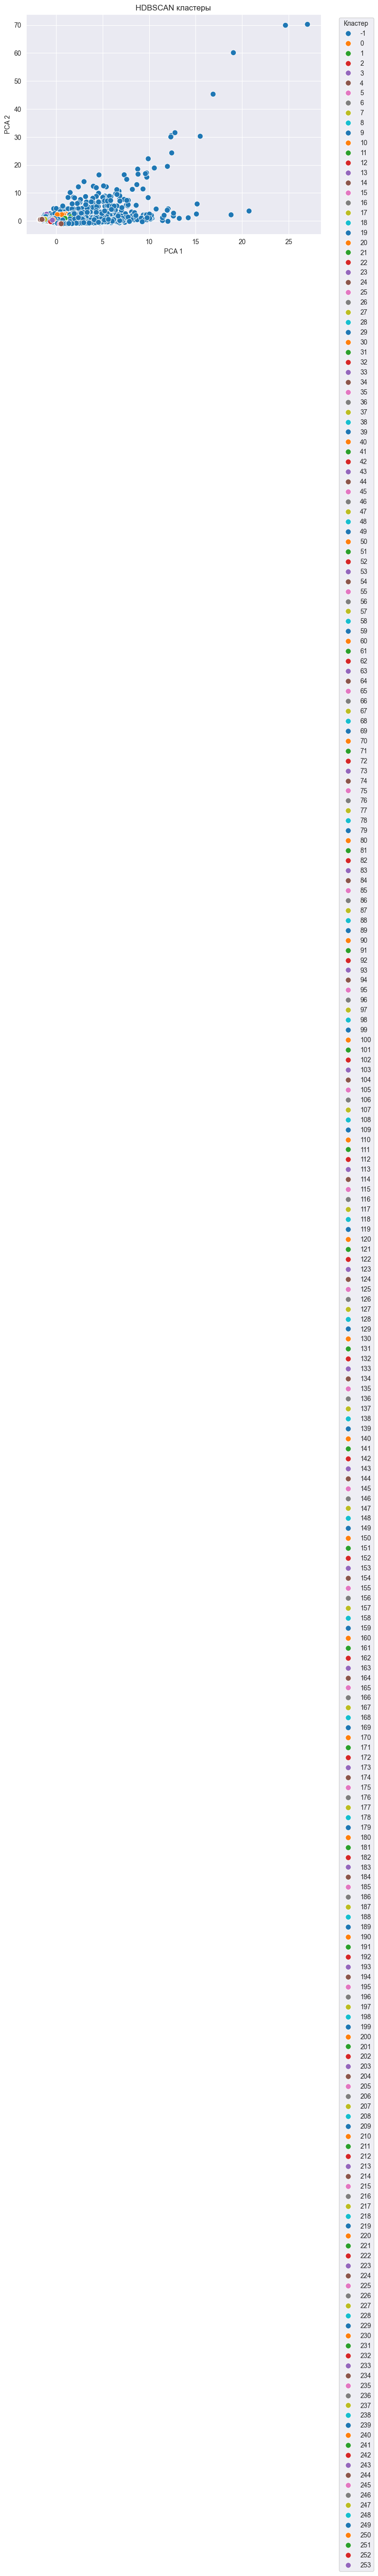

In [7]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sampled)

df_hdbscan_clusters['pca1'] = X_pca[:, 0]
df_hdbscan_clusters['pca2'] = X_pca[:, 1]

# Визуализация кластеров
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_hdbscan_clusters,
    x='pca1',
    y='pca2',
    hue='hdbscan_cluster',
    palette='tab10',
    s=70
)
plt.title("HDBSCAN кластеры")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Кластер", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


### Анализ кластеров

In [8]:
df_hdbscan_clusters['hdbscan_cluster'].value_counts()


hdbscan_cluster
-1      11864
 69       393
 131      367
 145      336
 10       334
        ...  
 2         30
 75        30
 185       30
 249       30
 119       30
Name: count, Length: 255, dtype: int64

### Силуэт оценка HDBSCAN

In [9]:
from sklearn.metrics import silhouette_score

# Отфильтруем шум
mask_core = hdb_labels != -1
X_core = X_sampled[mask_core]
labels_core = hdb_labels[mask_core]

if len(set(labels_core)) >= 2:
    sil_score = silhouette_score(X_core, labels_core)
    print(f"Silhouette Score (HDBSCAN): {sil_score:.3f}")
else:
    print("Недостаточно кластеров (без учёта шума) для силуэт-оценки.")


Silhouette Score (HDBSCAN): 0.725
